# Pysumma example
In this notebook we'll use pysumma to reproduce an experiment published in Clark et al. (2015). Data for this experiment are from Reynolds Mountain East is located in southwestern Idaho (Reba at al., 2009, 2011, 2012, 2014; Flerchinger et al., 2012). The experiment investigates the impact of different snow albedo parametrizations.

## References
Clark, M. P. et al. (2015), A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies, Water Resour. Res., 51, 2515–2542, doi:10.1002/2015WR017200.

Flerchinger, G. N., M. L. Reba, and D. Marks (2012), Measurement of surface energy fluxes from two Rangeland sites and comparison with a multilayer canopy model, J. Hydrometeorol., 13(3), 1038–1051, doi:10.1175/jhm-d-11-093.1

Reba, M. L., T. E. Link, D. Marks, and J. Pomeroy (2009), An assessment of corrections for eddy covariance measured turbulent fluxes over snow in mountain environments, Water Resour. Res., 45, W00d38, doi:10.1029/2008WR007045.

Reba, M. L., D. Marks, M. Seyfried, A. Winstral, M. Kumar, and G. Flerchinger (2011), A long-term data set for hydrologic modeling in a snowdominated mountain catchment, Water Resour. Res., 47, W07702, doi:10.1029/2010WR010030.

Reba, M. L., J. Pomeroy, D. Marks, and T. E. Link (2012), Estimating surface sublimation losses from snowpacks in a mountain catchment using eddy covariance and turbulent transfer calculations, Hydrol. Processes, 26(24), 3699–3711, doi:10.1002/hyp.8372.

Reba, M. L., D. Marks, T. E. Link, J. Pomeroy, and A. Winstral (2014), Sensitivity of model parameterizations for simulated latent heat flux at the snow surface for complex mountain sites, Hydrol. Processes, 28(3), 868–881, doi:10.1002/hyp.9619.

<br>

In [1]:
# modules 
import os
import pysumma as ps
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# SUMMA.exe location
executable = '/work/TALC/enci619.05_2024w/local/bin/summa.exe'

In [3]:
os.environ['LD_LIBRARY_PATH'] = '/global/software/netcdf/netcdfc-4.7.3_gnu730_hdf51105_openmpi402gnu730/lib:/global/software/hdf5/hdf5-1.10.5_gnu730_openmpi402gnu730/lib:/global/software/openmpi/openmpi-4.0.2_gnu730/lib:/global/software/gcc/gcc-7.3.0/lib64:/global/software/gcc/gcc-7.3.0/lib:/global/software/python/3.10.4/lib/:/work/TALC/enci619.05_2024w/local/lib64'
print(os.environ['LD_LIBRARY_PATH'])

## Reproduce the albedo decay rate experiment
The experiments in Clark et al. (2015) required the setup of two SUMMA instantiations, one with a constant albedo decay rate and one with a variable decay rate. Differences between both setups are only in the `alb_method` modeling decision and the parameter associated with both modelling approaches for albedo decay. We will define a PySUMMA instantiation for both setups.

### Model setup

In [5]:
# Define location of .exe and file manager
file_manager_constant = './settings/reynolds/summa_fileManager_reynoldsConstantDecayRate.txt'
file_manager_variable = './settings/reynolds/summa_fileManager_reynoldsVariableDecayRate.txt'

In [6]:
# Open pysumma simulations for both
s_constant = ps.Simulation(executable, file_manager_constant)
s_variable = ps.Simulation(executable, file_manager_variable)

<br>

Check the albedo settings in both simulation objects to make sure they are assigned correctly.

In [7]:
print('Available albedo decay options:' + str(s_constant.decisions['alb_method'].available_options))
print(str(s_constant.decisions['alb_method']) + ' in `constant` simulation.')
print(str(s_variable.decisions['alb_method']) + ' in `variable` simulation.')

Available albedo decay options:['conDecay', 'varDecay']
alb_method    conDecay             ! choice of albedo representation in `constant` simulation.
alb_method    varDecay             ! choice of albedo representation in `variable` simulation.


<br>

Ensure the output directories exist.

In [8]:
# Make the output directory if it doesn't exist
if not os.path.exists(s_constant.manager['outputPath'].value):
    os.makedirs(s_constant.manager['outputPath'].value)
    
if not os.path.exists(s_variable.manager['outputPath'].value):
    os.makedirs(s_variable.manager['outputPath'].value)    

### Model runs
We can now run the simulations for both cases.

In [9]:
s_constant.run('local', run_suffix='constantAlbedoDecayRate')
s_variable.run('local', run_suffix='variableAlbedoDecayRate')

# Check simulation status
print(s_constant.status)
print(s_variable.status)

Success
Success


### Output visualization
We'll briefly investigate the structure of the output files SUMMA generates. We'll load the files with `xarray`:

In [10]:
# output location
file_out_constant = './output/reynolds/reynolds_constantAlbedoDecayRate_timestep.nc'
file_out_variable = './output/reynolds/reynolds_variableAlbedoDecayRate_timestep.nc'

In [11]:
# Load the data
out_constant = xr.open_dataset(file_out_constant).isel(hru=0, gru=0).load() # pre-select the single hru and gru that are within the data
out_variable = xr.open_dataset(file_out_variable).isel(hru=0, gru=0).load()

<br>

Let's take a look at the content of this .nc file. Note that we could also use `s_constant.output` but these simulation objects do not persist between sessions. If you need to spread your work over multiple sessions, being able to work with the output files directly is useful. The SUMMA documentation (https://summa.readthedocs.io/en/latest/input_output/SUMMA_output/#summa-output-files) provides details about the output dimensions `ifcSoil`, `ifcToto`, `midSoil` and `midToto`. Dimension `time`, of course, represents time. The attributes of each data variable (accessed by clicking the document icon in each data variable row) provide a somewhat longer description of the variable and its units. The general attributes are a list of modelling decisions used to generate these simulations:

In [12]:
# Have a look at what is in the output .nc file -> use the dropdown arrows to check the contents
out_constant

<xarray.Dataset>
Dimensions:                  (time: 10945, midToto: 13, midSoil: 8,
                              ifcToto: 14, ifcSoil: 9)
Coordinates:
  * time                     (time) datetime64[ns] 2005-07-01 ... 2006-09-30
    hru                      int64 1001
    gru                      int64 1001
Dimensions without coordinates: midToto, midSoil, ifcToto, ifcSoil
Data variables: (12/39)
    pptrate                  (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    airtemp                  (time) float64 287.5 288.2 287.8 ... 284.2 283.9
    basin__SurfaceRunoff     (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    basin__ColumnOutflow     (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    basin__AquiferStorage    (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    basin__AquiferRecharge   (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                       ...
    scalarSurfaceRunoff      (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iLayerLiqFluxSoil        (time, ifcSoil) float64 -9.995e-09 ... 3.196e-10
    mLayerLiqFluxSoil        (time, midSoil) float64 -2.738e-07 ... -1.707e-09
    scalarTotalRunoff        (time) float64 4.063e-11 4.063e-11 ... 3.196e-10
    hruId                    int64 1001
    gruId                    int64 1001
Attributes: (12/32)
    summaVersion:     undefined
    buildTime:        Fri Feb  2 12:53:05 MST 2024
    gitBranch:        master-0-g3ca07b72
    gitHash:          3ca07b723ee876394c11b8521081fede2c168b39
    soilCatTbl:       ROSETTA
    vegeParTbl:       USGS
    ...               ...
    snowLayers:       CLM_2010
    compaction:       anderson
    thCondSnow:       jrdn1991
    thCondSoil:       mixConstit
    spatial_gw:       localColumn
    subRouting:       timeDlay

<br> 

Fortunately, out variable of interest `scalarSnowDepth` only has a time dimension. This makes plotting straightforward:

In [13]:
# Define the variable
var = 'scalarSnowDepth'

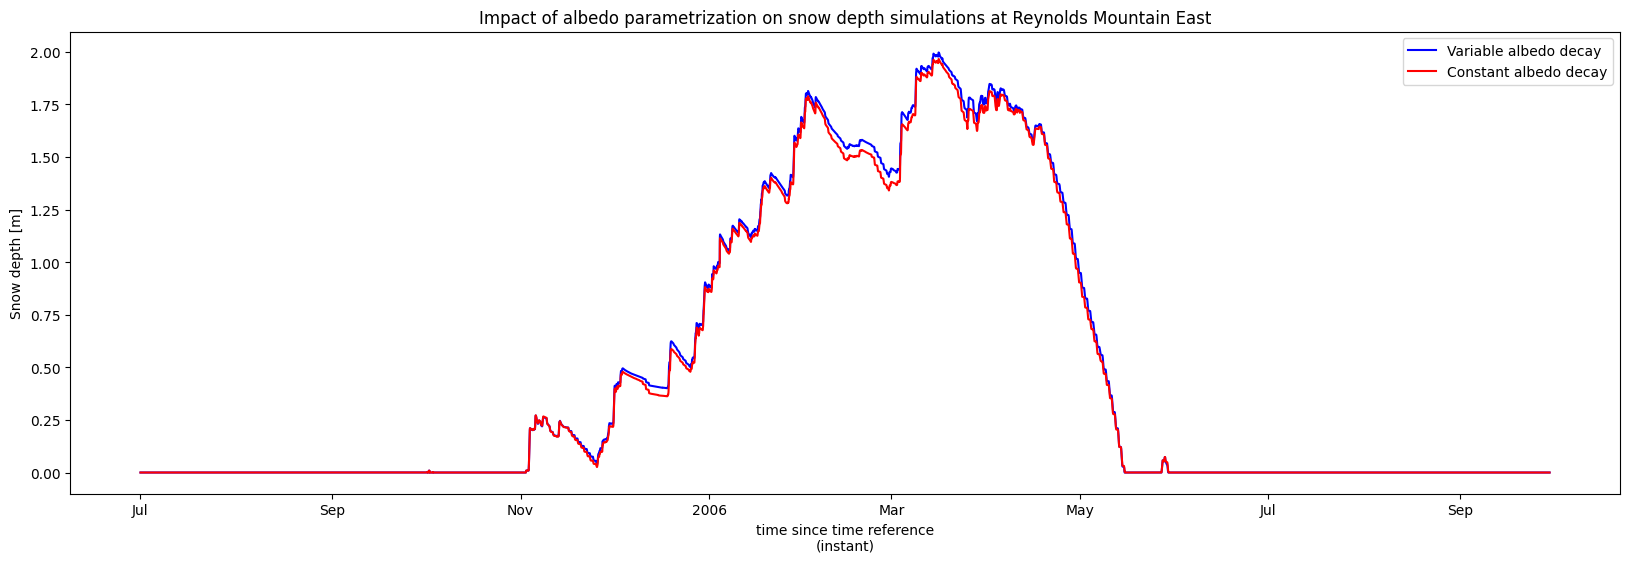

In [14]:
# plot both snow depth simulations against time
plt.figure(figsize=(20,6))
out_variable[var].plot(label='Variable albedo decay',color='b'); # we can use xarray's built-in plotting capability
out_constant[var].plot(label='Constant albedo decay',color='r');
plt.legend()
plt.title('Impact of albedo parametrization on snow depth simulations at Reynolds Mountain East')
plt.ylabel('Snow depth [m]');

Now let's add the observations to fully reproduce Fiure 6a of Clark et al. (2015).

In [15]:
# location of observation file
file_obs = './data/reynolds/ReynoldsCreek_valData.nc'

In [16]:
# Load the data
obs = xr.open_dataset(file_obs)

Snow depth is stored as `zs_sheltered` in this file ("sheltered" refers to a specific site with tree cover in the catchment - note that we also used forcing from the sheltered site). There are more observations than we had forcing data for, so we'll need to select an appropriate time period to plot. Note that the observations are in `cm`, whereas SUMMA's outputs are in `m`.

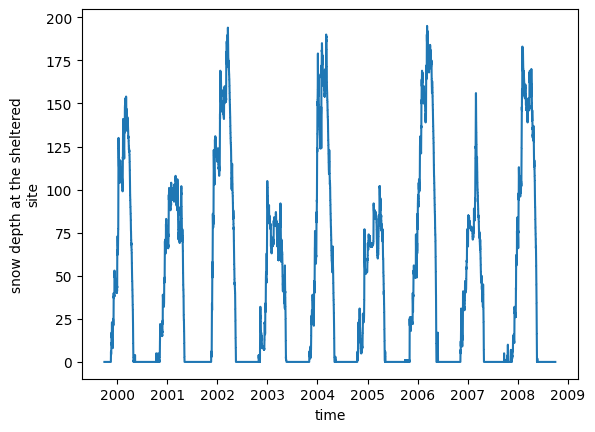

In [17]:
# Check the data
obs['zs_sheltered'].plot();

In [18]:
# Select the time period
times = ['2005-09-01','2006-09-01']

In [19]:
# we can't use xarray's plotting capabilities for this specific plot, 
# so we'll store the data in temporary variables for clarity
plt_time = obs['time'].sel(time=slice(times[0],times[1]))
plt_snow = obs['zs_sheltered'].sel(time=slice(times[0],times[1])) / 100 # convert cm > m

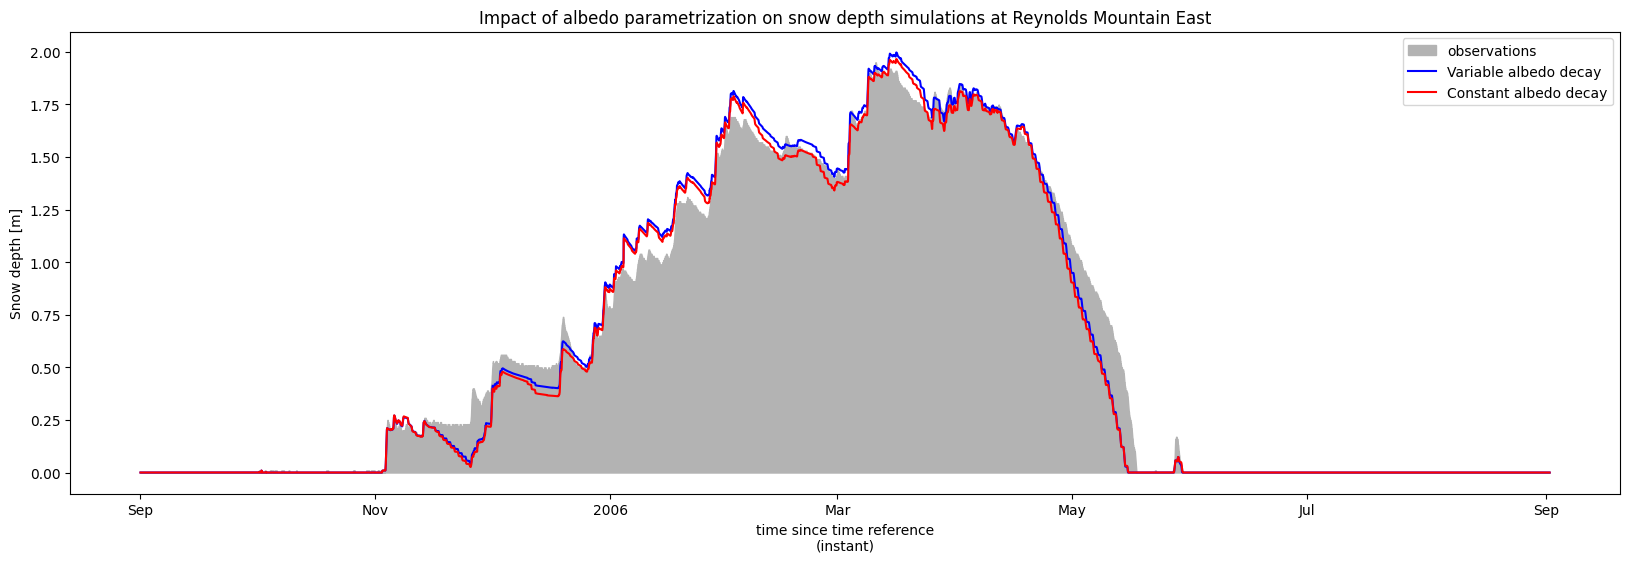

In [20]:
# Now we can re-create the plot
plt.figure(figsize=(20,6))
plt.fill_between(plt_time,plt_snow,color=[0.7,0.7,0.7],label='observations');
out_variable[var].sel(time=slice(times[0],times[1])).plot(label='Variable albedo decay',color='b'); 
out_constant[var].sel(time=slice(times[0],times[1])).plot(label='Constant albedo decay',color='r');
plt.legend()
plt.title('Impact of albedo parametrization on snow depth simulations at Reynolds Mountain East')
plt.ylabel('Snow depth [m]');

<br>

With this, we have reproduced the simulations in Figure 6 of Clark et al. (2015) and performed an experiment that shows the impact of two different process parametrizations, whilst keeping all other modelling decisions constant.